# Notebook for M3 assesment

This is a mock-up notebook for M3 deliverable for AIRGo project.

### Import of library

In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Backend.PandaPowerBackend import PandaPowerBackend
from grid2op.Agent import DoNothingAgent
from grid2op.Episode import EpisodeData
import numpy as np
import os
import shutil
from grid2op.gym_compat import GymEnv
from gym import Env
from gym.utils.env_checker import check_env
import tqdm
from grid2op.Runner import Runner

### Create a Grid2op environment

Here we load the l2rpn_case14_sandbox file, in the context of our project it should be France network as a whole for the final test.  

As you can see for the experience to be reproducible we can set a seed so the train/val/test sets are always the same. 

<strong>The backend will be changed from PandaPowerBackend to PypowsyblBackend</strong>.

The make function is highly customizable and a lot of parameters could be changed as well other classes.
For more details: https://grid2op.readthedocs.io/en/latest/makeenv.html#grid2op.MakeEnv.make 

In [2]:
env = grid2op.make("l2rpn_case14_sandbox",backend = PandaPowerBackend()) 
max_iter = 5  # we limit the number of iterations to reduce computation time. Put -1 if you don't want to limit it
env.seed(42)
obs = env.reset()

To create your train, val and test environment. Only needs to be run once !

In [7]:
nm_env_train, nm_env_val, nm_env_test = env.train_val_split_random(pct_val=1., pct_test=1., add_for_test="test")

In [8]:
train_env = grid2op.make("l2rpn_case14_sandbox_train")

### Then, we can visualize our network and the data associated with each node

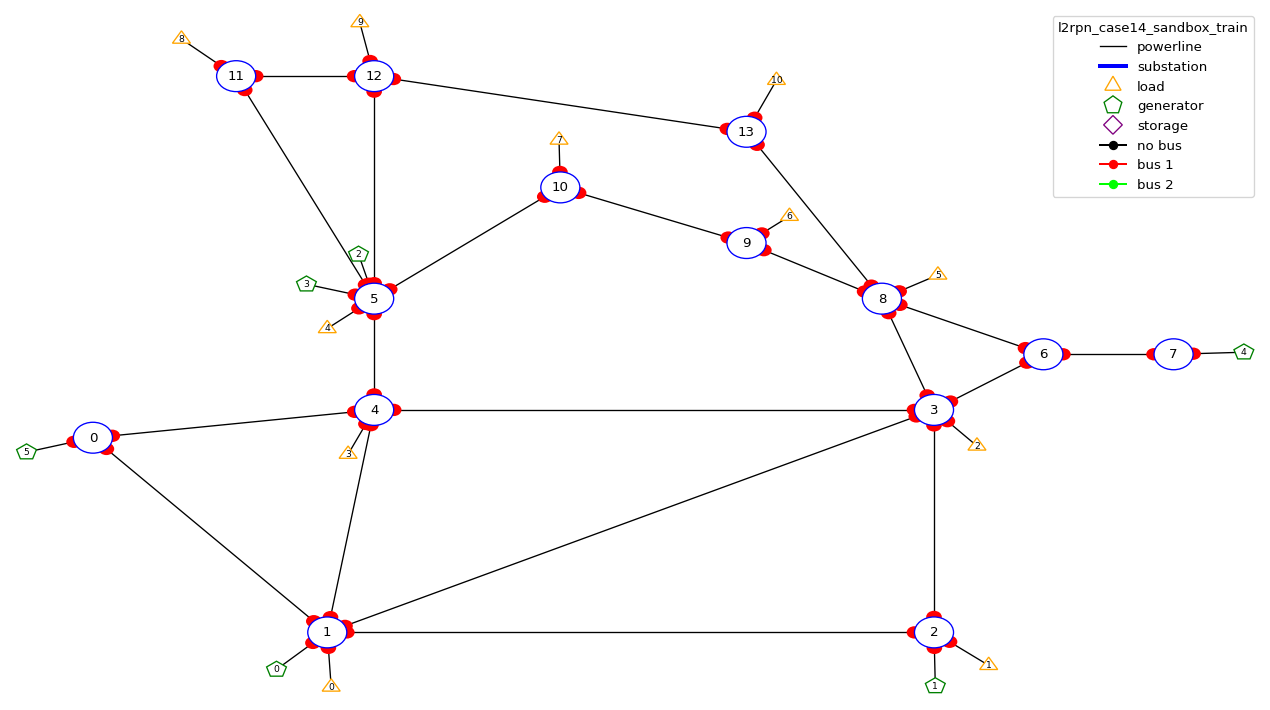

In [9]:
plot_helper = PlotMatplot(train_env.observation_space)
_ = plot_helper.plot_layout()

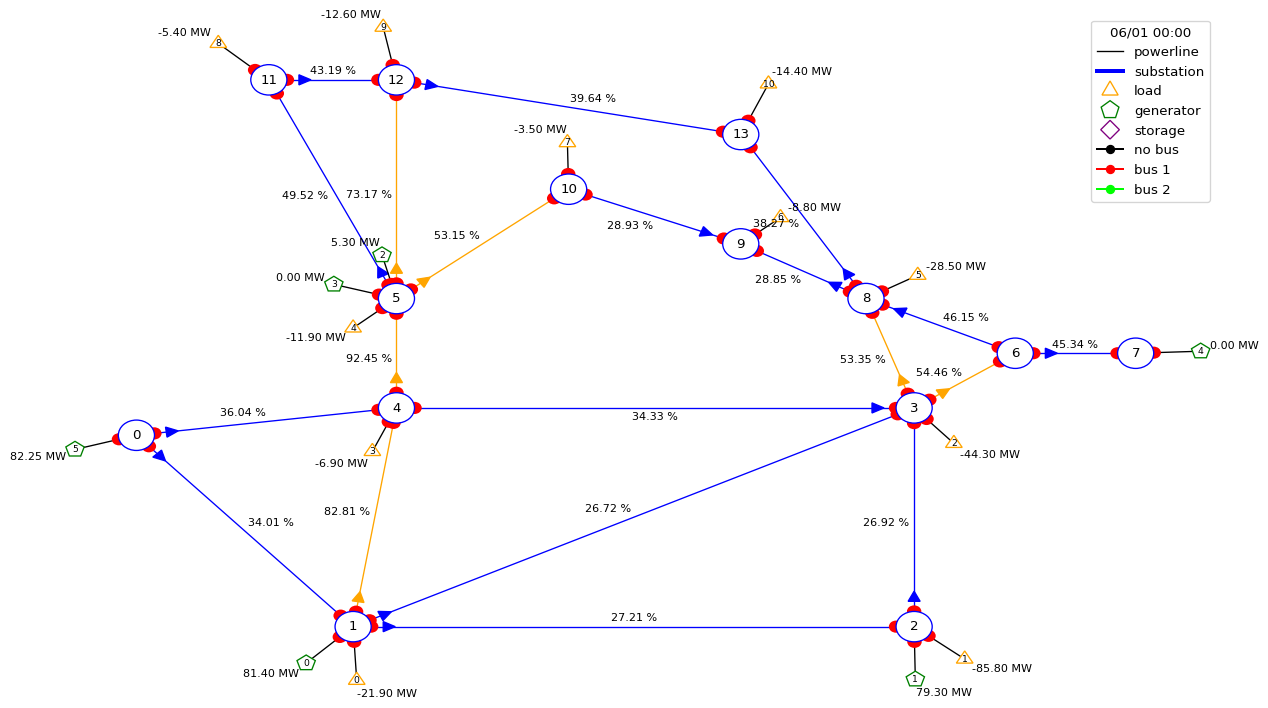

In [10]:
_ = plot_helper.plot_obs(obs)

### Different type of actions

<strong>There are five main types of possible actions</strong>:
* Injection actions
* Connection/Deconnection of a line
* Topological configuration at every substation  

     <em>If the correct parameters are given</em>
* Redispatching
* Curtailment



For more details: https://grid2op.readthedocs.io/en/latest/action.html

### Create an agent

An agent corresponds to an algorithm aimed at taking some actions (i.e. the actions mentioned above), regarding some observations on the grid and the possible rewards.

In our case we chose the DoNothingAgent which takes no action at any time step of the simulation. This agent is already pre-implemented. It is also possible to create one by following the Grid2op framework instructions and rules.

For further information: https://grid2op.readthedocs.io/en/latest/agent.html

This DoNothingAgent might be replaced by your personnal RL agent.

In [11]:
my_agent = DoNothingAgent

### Train an agent

We use the training environment to carry out the training phase on the model. 
It is also possible to use a complete gym environment.  

For more details: https://grid2op.readthedocs.io/en/latest/gym.html 

In [12]:
gym_env = GymEnv(env)

Every possible action can be listed:

In [14]:
gym_env.action_space

Dict('change_bus': MultiBinary(57), 'change_line_status': MultiBinary(20), 'curtail': Box([1. 1. 0. 0. 0. 1.], 1.0, (6,), float32), 'redispatch': Box([ -5. -10.   0.   0.   0. -15.], [ 5. 10.  0.  0.  0. 15.], (6,), float32), 'set_bus': Box(-1, 2, (57,), int32), 'set_line_status': Box(-1, 1, (20,), int32))

As well as possible observations:

In [15]:
gym_env.observation_space

Dict('_shunt_bus': Box(-2147483648, 2147483647, (1,), int32), '_shunt_p': Box(-inf, inf, (1,), float32), '_shunt_q': Box(-inf, inf, (1,), float32), '_shunt_v': Box(-inf, inf, (1,), float32), 'a_ex': Box(0.0, inf, (20,), float32), 'a_or': Box(0.0, inf, (20,), float32), 'actual_dispatch': Box([-140. -120.  -70.  -70.  -40. -100.], [140. 120.  70.  70.  40. 100.], (6,), float32), 'attention_budget': Box(0.0, inf, (1,), float32), 'current_step': Box(-2147483648, 2147483647, (1,), int32), 'curtailment': Box(0.0, 1.0, (6,), float32), 'curtailment_limit': Box(0.0, 1.0, (6,), float32), 'curtailment_limit_effective': Box(0.0, 1.0, (6,), float32), 'day': Discrete(32), 'day_of_week': Discrete(8), 'delta_time': Box(0.0, inf, (1,), float32), 'duration_next_maintenance': Box(-1, 2147483647, (20,), int32), 'gen_margin_down': Box(0.0, [ 5. 10.  0.  0.  0. 15.], (6,), float32), 'gen_margin_up': Box(0.0, [ 5. 10.  0.  0.  0. 15.], (6,), float32), 'gen_p': Box(-162.01, [302.01    282.01    232.01001 232.

These can be modified to fit a more classical form of reinforcment learning algorithms that deal with discrete action space by using:

```python
from grid2op.gym_compat import DiscreteActSpace
gym_env.action_space = DiscreteActSpace(training_env.action_space,
                                        attr_to_keep=["set_bus" , "set_line_status_simple"])
```  
and  
```python
from grid2op.gym_compat import BoxGymObsSpace
gym_env.observation_space = BoxGymObsSpace(training_env.observation_space,
                                           attr_to_keep=["rho"])
gym_env.observation_space
```

Because our agent 'DoNothingAgent' cannot be trained, hereafter is an example of how this could be done with a neural network.

Once you have your trainable agent, you can run some learning iterations by using: 
```python
from YOUR_PACKAGE import YOUR_MODEL
nn_model = YOUR_MODEL(env=gym_env,
               learning_rate=1e-3,
               policy="YOUR_POLICY",
               policy_kwargs={"net_arch": [100, 100, 100]}, # Just an example of architecture
               n_steps=2,
               batch_size=8,
               verbose=True,
               )
```  
and
```python
nn_model.learn(total_timesteps=LEARNING_ITERATION)
```

### Evaluate your agent

In [16]:
save_path = "saved_agent_DoNothingAgent"
path_save_results = "{}_results".format(save_path)
shutil.rmtree(path_save_results, ignore_errors=True)


runner = Runner(**env.get_params_for_runner(),
                agentClass=my_agent
               )
res = runner.run(nb_episode=1, 
                 max_iter=max_iter,
#                  pbar=tqdm,
                 path_save=f"./{path_save_results}")

In [17]:
print("The results for DoNothing agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for DoNothing agent are:
	For chronics with id 0000
		 - cumulative reward: 319.679596
		 - number of time steps completed: 5 / 5


In [18]:
os.listdir(path_save_results)
EpisodeData.list_episode(path_save_results)


[('c:\\Users\\yjanvier\\Documents\\Projets\\AIRGo\\pypowsybl-grid2opbackend\\saved_agent_DoNothingAgent_results',
  '0000')]

In [19]:
all_episodes = EpisodeData.list_episode(path_save_results)
this_episode = EpisodeData.from_disk(*all_episodes[0])
li_actions = this_episode.actions

Extraction of all the actions taken by the agent

In [20]:
for act in li_actions:
    dict_act_ = act.as_dict()

In [21]:
dict_act_

{}

As you can see, the dictionnary containing these actions is empty, which is rather logical since the agent does not take any action.

We can now check certain observation values for the episode. Typically the state of the lines (connected/disconnected) at each stage or the number of actual disconnections.

In [ ]:
li_observations = this_episode.observations
nb_real_disc = 0
for obs_ in li_observations:
    nb_real_disc += (obs_.line_status == False).sum()
print(f'Total number of disconnected powerlines cumulated over all the timesteps : {nb_real_disc}')

In [ ]:
actions_count = {}
for act in li_actions:
    act_as_vect = tuple(act.to_vect())
    if not act_as_vect in actions_count:
        actions_count[act_as_vect] = 0
    actions_count[act_as_vect] += 1
print("The agent did {} different valid actions:\n".format(len(actions_count)))

In [ ]:
for act in li_actions:
    print(act)